In [1]:
import numpy as np
import copy
import networkx as nx

In [32]:
class Factor_graph:
    
    no_child_edge=[]
    no_parent_edge=[]

    leaf_factors=[]
    
    edges =[]
    factors=[]

    def __init__(self):
        pass
        

class Factor(Factor_graph):
    
    def __init__(self):
        '''
        self.factor_name : can be int or str but should be unique
        self.linked_edge : list of Edge class objects , it stores variables connected to the factor
        self.factor_weight : the weight by which the outgoing msg is multiplied
        self.fac_2_var_msg : message passed from factor to its outgoing variables
        
        self.income_var : incoming variables to the factor
        self.outgo_var : outgoing variables from the factor
        '''
        
        super().__init__()
        self.factor_name=None
        self.linked_edge=[]
        self.factor_weight=1
        self.fac_2_var_msg = 1
        
        self.income_var=[]
        self.outgo_var=[]
        Factor_graph.factors.append(self)
    
    def add_factor(self, name, weight):
        '''
        name: string or integer - should be unique
        weight: int or float - its the weight by which outgoing messages are multiplied
        '''
        self.factor_name=name
        self.factor_weight=weight
        
    def link_variables(self, variable_dict):
        
        '''
        variable_dict : dict --> {"incoming":[], "outgoing":[]}
        
        len(variable_dict["outgoing"]) or len(variable_dict["incoming"]) != 0
        
        if there is no incoming variables : variable_dict["incoming"] = [None]
        
        There should be atleast one outgoing variables
        '''
        
        for i in variable_dict["incoming"]:
            self.income_var.append(i)
            self.linked_edge.append(i)
            
        for i in variable_dict["outgoing"]:
            self.outgo_var.append(i)
            self.linked_edge.append(i)
            
        if(self.income_var[0]==None):
            Factor_graph.leaf_factors.append(self)
            
            
    def compute_factor_msg(self): # check it whether it should be used or not
        
        '''
        compute the outgoing msg of the factor based on the incoming msgs
        '''
        
        fac_msg=0
        for i in range(0, len(self.linked_edge)):
            
            if(self.linked_edge[i] not in self.visited_edge):
                
                if(i==0 or fac_msg==0):
                    fac_msg =  np.copy(self.linked_edge[0].dist)
                
                else:
                    fac_msg = np.copy( np.outer(fac_msg, self.linked_edge[1].dist) )
                
                self.visited_edge.append(self.linked_edge[i])
                
        self.factor_msg = np.copy(fac_msg)
        
        
class Edge(Factor_graph):
    
    def __init__(self, name):
        '''
        name : variable name --> can be int or string but unique
        
        self.dist : distribution of the variable, it will be numpy array
        self.parent_factor : parent factor to which the variable is attached
        self.child_factor : child factor to which the variable is attached
        self.var_2_fac_msg : message passed from this variable to factor
        
        '''
        super().__init__()
        self.variable_name=name
        self.dist =None
        self.parent_factor=None
        self.child_factor=None
        self.var_2_fac_msg=1
        Factor_graph.edges.append(self)
        
    def add_edge(self, parent=None, child=None):
        
        '''
        parent : factor class object or none
        child : factor class object or none
        '''
        
        self.parent_factor = parent
        self.child_factor = child
                
        if(parent == None):
            Factor_graph.no_parent_edge.append(self)
            
        if(child == None):
            Factor_graph.no_child_edge.append(self)
        
    def add_distribution(self, distribution):
        
        '''
        distribution : numpy array
        '''
        self.dist = distribution
        self.var_2_fac_msg = np.copy(distribution)
        
        
class Inference(Factor_graph):
    
    def __init__(self):
        super().__init__()
        
        
    def print_factor(self, factor):
        '''
        Printing function to print the factor attributes
        
        factor : Factor class instance
        '''
        print("Factor_name : ",factor.factor_name)
        print("linked_edges : ",factor.linked_edge)
        print("Factor weight : ",factor.factor_weight)
        print("Fac_2_var msg : ",factor.fac_2_var_msg)
        
        print("Incoming variables :",factor.income_var)
        print("Outgoing variables :",factor.outgo_var)
        
    def print_variable(self, variable):
        
        '''
        printing function to print the variable attributes
        
        variable : Edge class instance
        '''
        print("variable name : ",variable.variable_name)
        print("Distribution : ",variable.dist)
        if(variable.parent_factor !=None):
            print("Parent factor : ",variable.parent_factor.factor_name)
        if(variable.child_factor != None):
            print("Child factor : ", variable.child_factor.factor_name)
        print("var_2_fac_msg : ",variable.var_2_fac_msg)
        
    def print_graph(self):
        
        variables = Factor_graph.edges
        
        graph_nodes=[]
        var_names=[]
        for var in variables:
            
            var_names.append(var.variable_name)
            if(var.child_factor !=None):
                graph_nodes.append( (var.variable_name, var.child_factor.factor_name) )
                
            if(var.parent_factor !=None):
            
                graph_nodes.append( (var.variable_name, var.parent_factor.factor_name) )
                
                
        g= nx.Graph()
        g.add_edges_from(graph_nodes)
        color_map=[]
        node_size_list =[]
        
        for i in g.nodes :
            
            if( i in var_names):
                
                color_map.append("cyan")
                node_size_list.append(500)
                
            else:
                color_map.append("red")
                node_size_list.append(1000)
        
        nx.draw(g, node_color=color_map, node_size=node_size_list, edge_color='blue', with_labels=True)
        print("Blue color nodes : Variables attached to edges between factors")
        print("Red color nodes : Factors")
        
            
    def forward_path(self, f_path, query):
        
        '''
        Function to find the forward message passing path
        
        f_path : path found using depth first search from the function traversing (type : list)
        query : variable that is querried (tyep : Edge class object)
        '''
        #forward_msg_passing
        start_nodes=[]
        start_facs=[]
        for var in f_path:
            if(var in Factor_graph.no_child_edge or var in Factor_graph.no_parent_edge):
                start_nodes.append(var)
                
            elif(var.parent_factor in Factor_graph.leaf_factors):
                start_facs.append(var.parent_factor)
                
        f_path={}
        visited=[]
        for i in start_nodes:
            stack=[i]
            while(True):
                
                if(stack==[]):
                    break
                    
                var = stack.pop(0)
                if(var.child_factor!=None):
                    f_path[var]=var.child_factor
                    f_path[var.child_factor]=[]
                    for v in var.child_factor.outgo_var:
                        if(v != query):
                            stack.append(v)
                            f_path[var.child_factor].append(v)
          # Uncomment the following lines to print forward path
#         print("Forward_msg_path")
#         for i in list(dict.keys(f_path)):
#             if(isinstance(i, type(Factor()))):
#                 print(i.factor_name,":", f_path[i])
                
#             else:
#                 print(i.variable_name,":", f_path[i].factor_name)
        return f_path
    
    
    def backward_path(self, b_path, query):
        '''
        Function to find the forward message passing path
        
        b_path : backward path found using depth first search from the function traversing (type : list)
        query : variable that is querried (type : Edge class object)
        '''
        start_nodes=[]
        start_facs=[]
        for var in b_path:
            if(var in Factor_graph.no_child_edge or var in Factor_graph.no_parent_edge):
                start_nodes.append(var)
                
            elif(var.child_factor in Factor_graph.leaf_factors):
                start_facs.append(var.child_factor)
                
        b_path={}
        
        for i in start_nodes:
            stack=[i]
            
            while(True):
                
                if(stack==[]):
                    break
                    
                var= stack.pop(0)
                
                if(var.parent_factor!=None):
                    b_path[var]=var.parent_factor
                    b_path[var.parent_factor]=[]
                    for v in var.parent_factor.income_var:
                        if(v != query):
                            stack.append(v)
                            b_path[var.parent_factor].append(v)
        
          # Uncomment the following lines to print back ward path
#         print("Backward_msg_path")
#         for i in list(dict.keys(b_path)):
#             if(isinstance(i, type(Factor()))):
#                 print(i.factor_name,":", b_path[i])
                
#             else:
#                 print(i.variable_name,":", b_path[i].factor_name)
        return b_path

        
    def traversing(self, query):
        
        '''
        This function helps to find the message passing path for forward and backward, which is used to compute
        the forward and backward messages

        query : The variable that is querried (type : Edge class instance)
        '''
        
        f_path=[]
        b_path=[]
        
        #Computing forward message through dfs
        for count in range(0,2,1):
            v_edge=[]
            stack=[query]
            while(True):

                if(len(stack)==0):
                    break

                var = stack.pop()
                if(var not in v_edge):
                    v_edge.append(var)
                    
                    if(count==0):
                        if(var.parent_factor != None):
                            if(var.parent_factor.income_var !=None):
                                for i in var.parent_factor.income_var:
                                    stack.append(i)
                                    
                    if(count==1):
                        if(var.child_factor != None):
                            if(var.child_factor.outgo_var !=None):
                                for i in var.child_factor.outgo_var:
                                    stack.append(i)
            if(count==0):
                f_path = v_edge[::-1]
            
            else:
                b_path = v_edge[::-1]
                
                
        
        f_msg_path = self.forward_path(f_path, query)
        
        b_msg_path = self.backward_path(b_path, query)
        
        return f_msg_path, b_msg_path
        
        
    def compute_forward_msg(self, forward_path, query):
        
        '''
        This function is used to compute the forward message based on the forward msg path obtained from
        the traversing function
        
        forward_path : obtained from traversing function (Type : dict() containing variables and factors)
        
        query : The variable that is queried (type : Edge class object)
        '''
        
        for key in list(dict.keys(forward_path)):
            
            if(isinstance(key, type(Edge("")))):
                forward_path[key].fac_2_var_msg = np.copy(np.outer(forward_path[key].fac_2_var_msg,
                                                                  key.var_2_fac_msg))        
                
            elif(isinstance(key, type(Factor()) ) ):
                
                for var in forward_path[key]:
                                   
                    var.var_2_fac_msg = np.copy(np.outer(var.var_2_fac_msg, key.fac_2_var_msg))
                    var.var_2_fac_msg = self.marginalize_msg (np.copy(var.var_2_fac_msg))
                    
                    
        return np.copy(self.marginalize_msg(query.parent_factor.fac_2_var_msg))
    
    def compute_backward_msg(self, backward_path, query):

        '''
        This function is used to compute the backward message based on the forward msg path obtained from
        the traversing function
        
        backward_path : obtained from traversing function (Type : dict() containing variables and factors)
        
        query : The variable that is queried (type : Edge class object)
        '''
        for key in list(dict.keys(backward_path)):
            
            if(isinstance(key, type(Edge("")))):
                
                backward_path[key].fac_2_var_msg = np.copy( np.outer(backward_path[key].fac_2_var_msg,
                                                                    key.var_2_fac_msg))
            elif(isinstance(key, type(Factor()) ) ):
                
                for var in backward_path[key]:
                    
                    var.var_2_fac_msg = np.copy( np.outer( var.var_2_fac_msg, key.fac_2_var_msg))
                    
                    var.var_2_fac_msg = self.marginalize_msg (np.copy(var.var_2_fac_msg))
                
        
        return np.copy(self.marginalize_msg(query.child_factor.fac_2_var_msg))
            
    
    def marginalize_msg(self, var_2_fac_msg):
        
        '''
        This function is used to marginalize the message in the variable which will be passed on to the 
        succeeding factor
        
        var_2_fac_msg : numpy array
        '''
        
        var_2_fac_msg = np.sum(var_2_fac_msg, axis=0)
        return var_2_fac_msg
        
    def infer_variable(self, query):
        
        '''
        This function calls the necessary functions like traversing, compute_forward_msg, compute_backward_msg
        and marginalize_msg to find P(query variable)
        
        Query: variable that is querried (Type : Edge class instance)
        '''
        
        forward_path, backward_path = self.traversing(query)

        
        forward_msg = self.compute_forward_msg(forward_path, query)
        
        backward_msg = self.compute_backward_msg(backward_path, query)
        
        query_out =  self.marginalize_msg(np.outer(forward_msg, backward_msg))
        print(query.variable_name, " : ", query_out)

In [33]:
s = Inference()
fa = Factor()
fb = Factor()
fc = Factor()
x1 = Edge("x1")
x2 = Edge("x2")
x3 = Edge("x3")
x4 = Edge("x4")
x5 = Edge("x5")

In [34]:
fa.add_factor("Fa", 10)
fb.add_factor("Fb", 2)
fc.add_factor("Fc", 1)

fa.link_variables({"incoming":[x1], "outgoing":[x2]})
fb.link_variables({"incoming":[x2, x3], "outgoing":[x4]})
fc.link_variables({"incoming":[x4], "outgoing":[x5]})

x1.add_edge(None, fa)
x2.add_edge(fa, fb)
x3.add_edge(None, fb)
x4.add_edge(fb, fc)
x5.add_edge(fc, None)

x1.add_distribution(np.array([[0.3, 0.4]]))
x2.add_distribution(np.array([[0.2, 0.8]]))
x3.add_distribution(np.array([[0.4, 0.6]]))
x4.add_distribution(np.array([[0.5, 0.5]]))
x5.add_distribution(np.array([[0.3, 0.4]]))


In [35]:
s.infer_variable(x2)

x2  :  [0.21 0.28]


Blue color nodes : Variables attached to edges between factors
Red color nodes : Factors


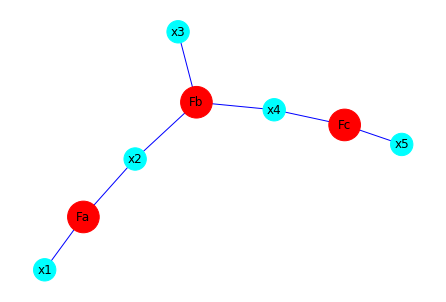

In [36]:
s.print_graph()